In [1]:
# =============================================================================
# 📥 IMPORTS AND SETUP
# =============================================================================

import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, auc

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# =============================================================================
# 📊 ANALYSIS FUNCTIONS
# =============================================================================

def analyze_consensus_docking(df_all_poses,
                              df_best_poses, 
                              top_n_clusters=10):
    """
    Comprehensive analysis of consensus docking results.
    
    Parameters:
    -----------
    df_all_poses : polars.DataFrame
        Input dataframe with all consensus docking results (for cluster analysis)
    df_best_poses : polars.DataFrame
        Input dataframe with best poses already selected and filtered
    top_n_clusters : int
        Number of top cavity clusters to analyze (default: 10)
    
    Returns:
    --------
    dict : Dictionary containing statistics
    """
    
    results = {}
    
    # =============================================================================
    # 1. BASIC STATISTICS
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 1: Computing basic statistics")
    print("="*80)
    
    unique_pairs = df_all_poses['compound_target_pair'].n_unique()
    pair_sample_type = df_all_poses.select(['compound_target_pair', 'sample_type']).unique()
    positive_pairs = pair_sample_type.filter(pl.col('sample_type') == 'positive').height
    negative_pairs = pair_sample_type.filter(pl.col('sample_type') == 'negative_balanced').height
    
    print(f"   Unique compound-target pairs: {unique_pairs:,}")
    print(f"   ✅ Positive pairs: {positive_pairs:,}")
    print(f"   ❌ Negative pairs: {negative_pairs:,}")
    
    results['stats'] = {
        'unique_pairs': unique_pairs,
        'positive_pairs': positive_pairs,
        'negative_pairs': negative_pairs
    }
    
    # =============================================================================
    # 3. CLUSTER ANALYSIS
    # =============================================================================
    print("\n" + "="*80)
    print("🏷️  STEP 3: Analyzing cavity clusters")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        cluster_counts = df_all_poses.select(['cavity_cluster_id', 'compound_target_pair', 'sample_type']).unique().group_by('cavity_cluster_id').agg([
            pl.len().alias('unique_compound_target_pairs'),
            pl.when(pl.col('sample_type') == 'positive').then(1).otherwise(0).sum().alias('positive_pairs'),
            pl.when(pl.col('sample_type') == 'negative_balanced').then(1).otherwise(0).sum().alias('negative_pairs')
        ]).sort('unique_compound_target_pairs', descending=True)
        
        print(f"\n   Top {top_n_clusters} cavity clusters:")
        print(cluster_counts.head(top_n_clusters).to_pandas().to_string())
        results['cluster_counts'] = cluster_counts
    
    # =============================================================================
    # 4. VIOLIN PLOTS - OVERALL DISTRIBUTIONS
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 4: Generating overall distribution violin plots")
    print("="*80)
    
    if df_best_poses.height > 0:
        df_plot = df_best_poses.to_pandas()
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        metrics = [
            ('RMSD', 'RMSD (Å)'),
            ('GOLD_Score', 'GOLD Score'),
            ('Smina_Score', 'SMINA Score'),
            ('LeDock_Score', 'LeDock Score')
        ]
        
        for idx, (metric, label) in enumerate(metrics):
            sns.violinplot(
                data=df_plot,
                x='sample_type',
                y=metric,
                ax=axes[idx],
                palette={'positive': '#2ecc71', 'negative_balanced': '#e74c3c'}
            )
            axes[idx].set_title(f'{label} Distribution', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Sample Type', fontsize=10)
            axes[idx].set_ylabel(label, fontsize=10)
            axes[idx].tick_params(axis='x', rotation=15)
            axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
        
        fig.suptitle('Distributions of RMSD and Scores by Sample Type', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        print("   ✅ Overall violin plots complete")
    
    # =============================================================================
    # 5. ROC CURVES - OVERALL
    # =============================================================================
    print("\n" + "="*80)
    print("📈 STEP 5: Generating overall ROC curves")
    print("="*80)
    
    if df_best_poses.height > 0:
        df_roc = df_best_poses.to_pandas()
        df_roc['label'] = df_roc['sample_type'].map({'positive': 1, 'negative_balanced': 0})
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        metrics = [
            ('RMSD', 'RMSD (Å)', True),
            ('GOLD_Score', 'GOLD Score', False),
            ('Smina_Score', 'SMINA Score', True),
            ('LeDock_Score', 'LeDock Score', True)
        ]
        
        for idx, (metric, label, invert) in enumerate(metrics):
            if metric in df_roc.columns:
                df_metric = df_roc[['label', metric]].dropna()
                
                if len(df_metric) > 0:
                    scores = -df_metric[metric] if invert else df_metric[metric]
                    fpr, tpr, _ = roc_curve(df_metric['label'], scores)
                    roc_auc = auc(fpr, tpr)
                    
                    axes[idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                    axes[idx].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
                    axes[idx].set_title(f'ROC Curve for {label}', fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel('False Positive Rate', fontsize=10)
                    axes[idx].set_ylabel('True Positive Rate', fontsize=10)
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(alpha=0.3, linestyle='--')
                    axes[idx].set_xlim([0.0, 1.0])
                    axes[idx].set_ylim([0.0, 1.05])
        
        fig.suptitle('ROC Curves for Metrics in Distinguishing Positive vs Negative Samples', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        print("   ✅ Overall ROC curves complete")
    
    # =============================================================================
    # 6. VIOLIN PLOTS - BY CAVITY CLUSTER
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 6: Generating cavity cluster violin plots")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        df_plot = df_all_poses.to_pandas()
        top_clusters = df_plot['cavity_cluster_id'].value_counts().head(top_n_clusters).index.tolist()
        
        metrics = [
            ('Smina_Score', 'SMINA Score'),
            ('LeDock_Score', 'LeDock Score'),
            ('GOLD_Score', 'GOLD Score')
        ]
        
        for metric, metric_label in metrics:
            if metric in df_plot.columns:
                print(f"   Plotting {metric_label}...")
                
                fig, axes = plt.subplots(2, 5, figsize=(20, 8))
                axes = axes.flatten()
                
                for idx, cluster_id in enumerate(top_clusters):
                    cluster_data = df_plot[df_plot['cavity_cluster_id'] == cluster_id]
                    
                    sns.violinplot(
                        data=cluster_data,
                        x='sample_type',
                        y=metric,
                        ax=axes[idx],
                        palette={'positive': '#2ecc71', 'negative_balanced': '#e74c3c'}
                    )
                    axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel('Sample Type', fontsize=10)
                    axes[idx].set_ylabel(metric_label, fontsize=10)
                    axes[idx].tick_params(axis='x', rotation=15)
                    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
                
                fig.suptitle(f'{metric_label} Distributions by Sample Type for Top {top_n_clusters} Cavity Clusters', 
                             fontsize=14, fontweight='bold', y=0.995)
                plt.tight_layout()
                plt.show()
        
        print("   ✅ Cluster violin plots complete")
    
    # =============================================================================
    # 7. ROC CURVES - BY CAVITY CLUSTER
    # =============================================================================
    print("\n" + "="*80)
    print("📈 STEP 7: Generating cavity cluster ROC curves")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        df_roc = df_all_poses.to_pandas()
        df_roc['label'] = df_roc['sample_type'].map({'positive': 1, 'negative_balanced': 0})
        top_clusters = df_roc['cavity_cluster_id'].value_counts().head(top_n_clusters).index.tolist()
        
        metrics = [
            ('Smina_Score', 'SMINA Score', True),
            ('LeDock_Score', 'LeDock Score', True),
            ('GOLD_Score', 'GOLD Score', False)
        ]
        
        for metric, metric_label, invert in metrics:
            if metric in df_roc.columns:
                print(f"   Plotting ROC curves for {metric_label}...")
                
                fig, axes = plt.subplots(2, 5, figsize=(20, 8))
                axes = axes.flatten()
                
                for idx, cluster_id in enumerate(top_clusters):
                    cluster_data = df_roc[df_roc['cavity_cluster_id'] == cluster_id][['label', metric]].dropna()
                    
                    if len(cluster_data) > 0 and len(cluster_data['label'].unique()) > 1:
                        scores = -cluster_data[metric] if invert else cluster_data[metric]
                        fpr, tpr, _ = roc_curve(cluster_data['label'], scores)
                        roc_auc = auc(fpr, tpr)
                        
                        axes[idx].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
                        axes[idx].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
                        axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                        axes[idx].set_xlabel('FPR', fontsize=10)
                        axes[idx].set_ylabel('TPR', fontsize=10)
                        axes[idx].legend(loc='lower right', fontsize=8)
                        axes[idx].grid(alpha=0.3, linestyle='--')
                        axes[idx].set_xlim([0.0, 1.0])
                        axes[idx].set_ylim([0.0, 1.05])
                    else:
                        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=10)
                        axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                
                fig.suptitle(f'ROC Curves for {metric_label} - Top {top_n_clusters} Cavity Clusters', 
                             fontsize=14, fontweight='bold', y=0.995)
                plt.tight_layout()
                plt.show()
        
        print("   ✅ Cluster ROC curves complete")
    
    # =============================================================================
    # SUMMARY
    # =============================================================================
    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print("="*80)
    print(f"   Total figures generated: ~{4 + 3 + 3} plots")
    print(f"   Results dictionary keys: {list(results.keys())}")
    
    return results

print("✅ Analysis function defined successfully!")

✅ Analysis function defined successfully!


In [3]:
# =============================================================================
# 📥 LOAD PREPARED CONSENSUS DOCKING DATA
# =============================================================================

# Configuration
DATA_FILE = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/combined_filtered_annotated_docking_results.parquet"

print("🔍 Loading prepared consensus docking data...")
print(f"📁 File: {DATA_FILE}")

if not os.path.exists(DATA_FILE):
    print("\n❌ Error: Prepared data file not found!")
    print("   Please run the data preparation pipeline first:")
    print("   - Notebook: data_preparation_pipeline.ipynb")
    print("   - This will create the required parquet file")
    combined_results = pl.DataFrame()
else:
    # Load the data
    combined_results = pl.read_parquet(DATA_FILE)
    
    print(f"\n✅ Data loaded successfully!")
    print(f"   Shape: {combined_results.shape}")
    print(f"   Rows: {combined_results.height:,}")
    print(f"   Columns: {combined_results.width}")
    print(f"   Memory: {combined_results.estimated_size() / (1024*1024):.1f} MB")
    
    # Verify required columns
    required_cols = [
        'drugbank_id', 'uniprot_id', 'cavity_index',
        'RMSD', 'Score1', 'Score2', 'LeDock_Score',
        'Tool1', 'Tool2', 'sample_type', 'cavity_cluster_id'
    ]
    
    missing_cols = [col for col in required_cols if col not in combined_results.columns]
    
    if missing_cols:
        print(f"\n⚠️  Warning: Missing expected columns: {missing_cols}")
        print("   Some analyses may not work correctly.")
    else:
        print(f"\n✅ All required columns present")
    
    # Show sample type distribution
    if 'sample_type' in combined_results.columns:
        sample_counts = combined_results.group_by('sample_type').agg(pl.len()).sort('sample_type')
        print(f"\n📊 Sample Type Distribution:")
        for row in sample_counts.iter_rows(named=True):
            print(f"   {row['sample_type']}: {row['len']:,}")
    
    # Show tool distribution
    if 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
        tools = set(combined_results['Tool1'].unique().to_list() + combined_results['Tool2'].unique().to_list())
        tools = [t for t in tools if t is not None]
        print(f"\n🔧 Tools in dataset: {sorted(tools)}")
    
    print(f"\n🎯 Dataset ready for research question analysis!")

🔍 Loading prepared consensus docking data...
📁 File: /media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/combined_filtered_annotated_docking_results.parquet

✅ Data loaded successfully!
   Shape: (2608088, 46)
   Rows: 2,608,088
   Columns: 46
   Memory: 1200.6 MB

✅ All required columns present

📊 Sample Type Distribution:
   negative_balanced: 1,304,044
   positive: 1,304,044

🔧 Tools in dataset: ['GOLD', 'LeDock', 'Smina']

🎯 Dataset ready for research question analysis!

✅ Data loaded successfully!
   Shape: (2608088, 46)
   Rows: 2,608,088
   Columns: 46
   Memory: 1200.6 MB

✅ All required columns present

📊 Sample Type Distribution:
   negative_balanced: 1,304,044
   positive: 1,304,044

🔧 Tools in dataset: ['GOLD', 'LeDock', 'Smina']

🎯 Dataset ready for research question analysis!


In [32]:
tool_name = 'GOLD'
df_best_pose_consensus = combined_results.filter(
    (pl.col('Tool1') == tool_name) | (pl.col('Tool2') == tool_name)
).filter(
    pl.col(tool_name).is_not_null()
)
df_best_pose_consensus = df_best_pose_consensus.sort(tool_name).group_by('compound_target_pair',maintain_order=True).first()

ColumnNotFoundError: unable to find column "GOLD"; valid columns: ["Tool1", "Tool2", "PoseNumber1", "PoseNumber2", "Score1", "Score2", "File1", "File2", "RMSD", "source_file", "source_dir", "file_size_mb", "source_type", "drugbank_id", "uniprot_id", "gene_name", "cavity_index", "Pose", "SMINA_Score", "Score", "S(PLP)", "S(hbond)", "S(cho)", "S(metal)", "DE(clash)", "DE(tors)", "time", "LeDock_Score", "primary_tool", "compound_target_pair", "GOLD_Score", "Smina_Score", "extracted_drugbank_id", "extracted_gene_name", "extracted_uniprot_id", "extracted_cavity_index", "cavity_cluster_id", "ic50_value", "ic50_unit", "measurement_type", "operator", "pubchem_cid", "activity", "n_measurements", "sample_type", "Gene_Name"]

In [ ]:
len(df_best_pose_consensus)

3123


📊 STEP 1: Computing basic statistics
   Unique compound-target pairs: 3,123
   ✅ Positive pairs: 1,263
   ❌ Negative pairs: 1,860

🏷️  STEP 3: Analyzing cavity clusters

   Top 10 cavity clusters:
   cavity_cluster_id  unique_compound_target_pairs  positive_pairs  negative_pairs
0                NaN                          2497            1112            1385
1                6.0                           121              76              45
2              245.0                            96              46              50
3                5.0                            78              46              32
4              205.0                            77              51              26
5              310.0                            64              30              34
6               33.0                            60              37              23
7              144.0                            48              32              16
8              137.0                            47     

/tmp/ipykernel_1574525/899674733.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


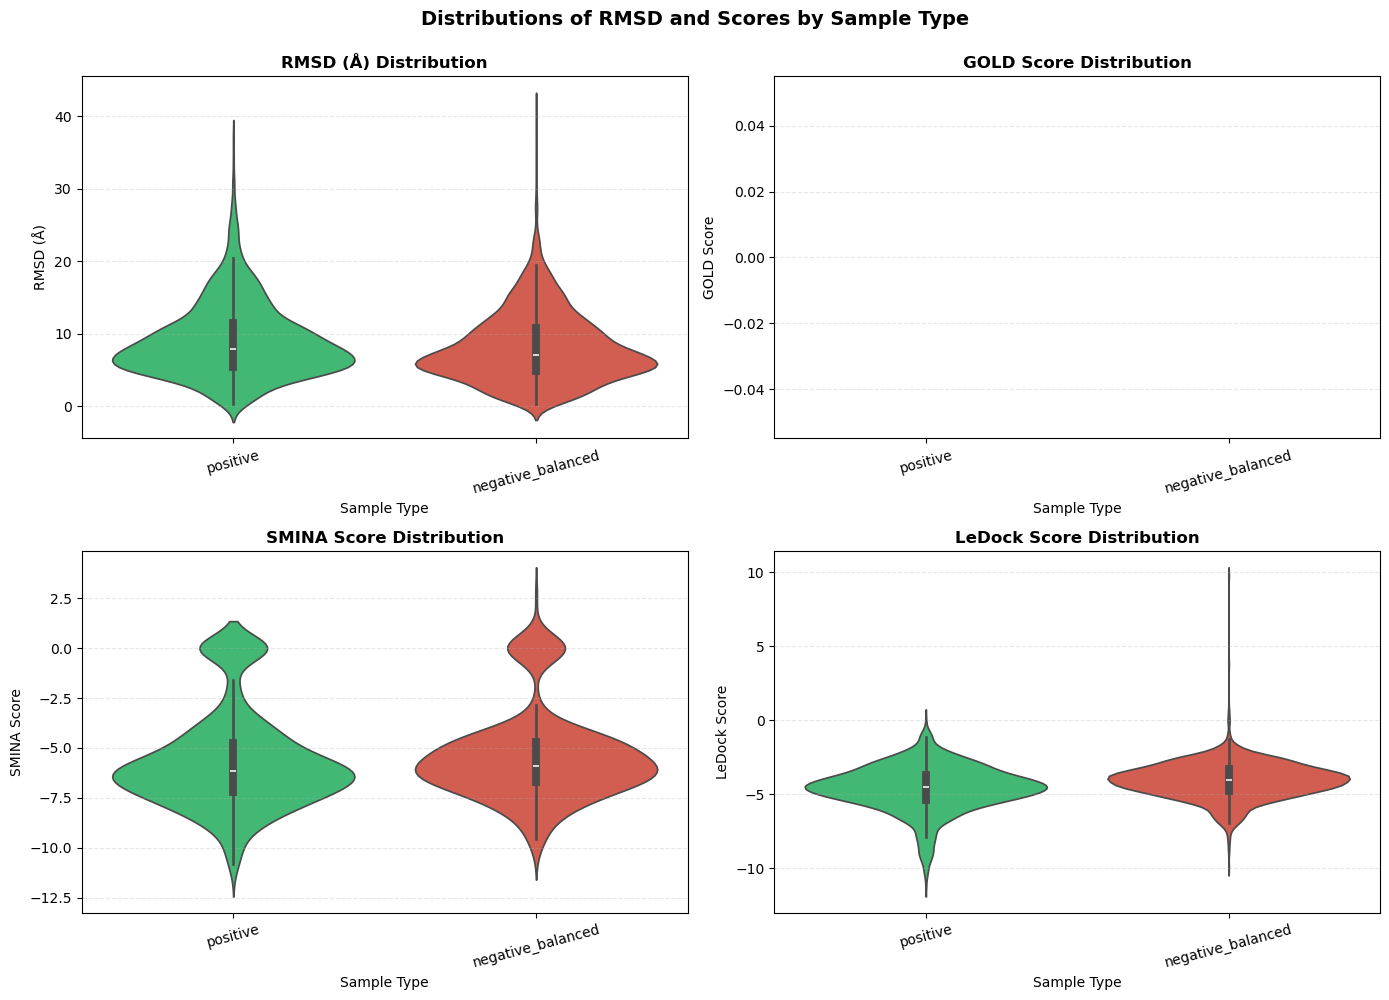

   ✅ Overall violin plots complete

📈 STEP 5: Generating overall ROC curves


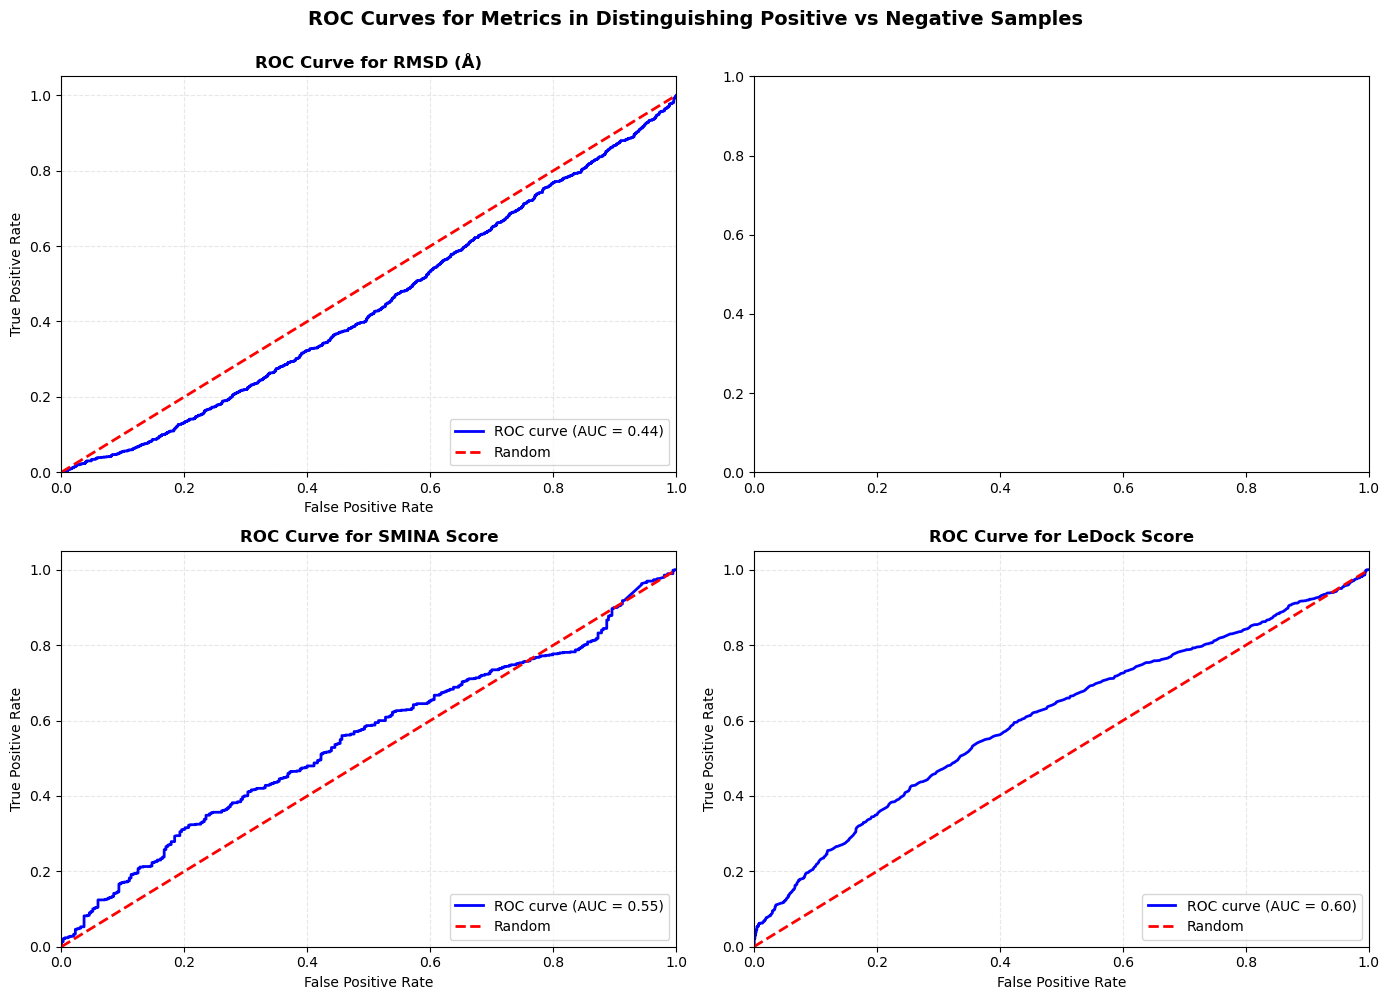

   ✅ Overall ROC curves complete

📊 STEP 6: Generating cavity cluster violin plots
   Plotting SMINA Score...
   Plotting SMINA Score...


/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733

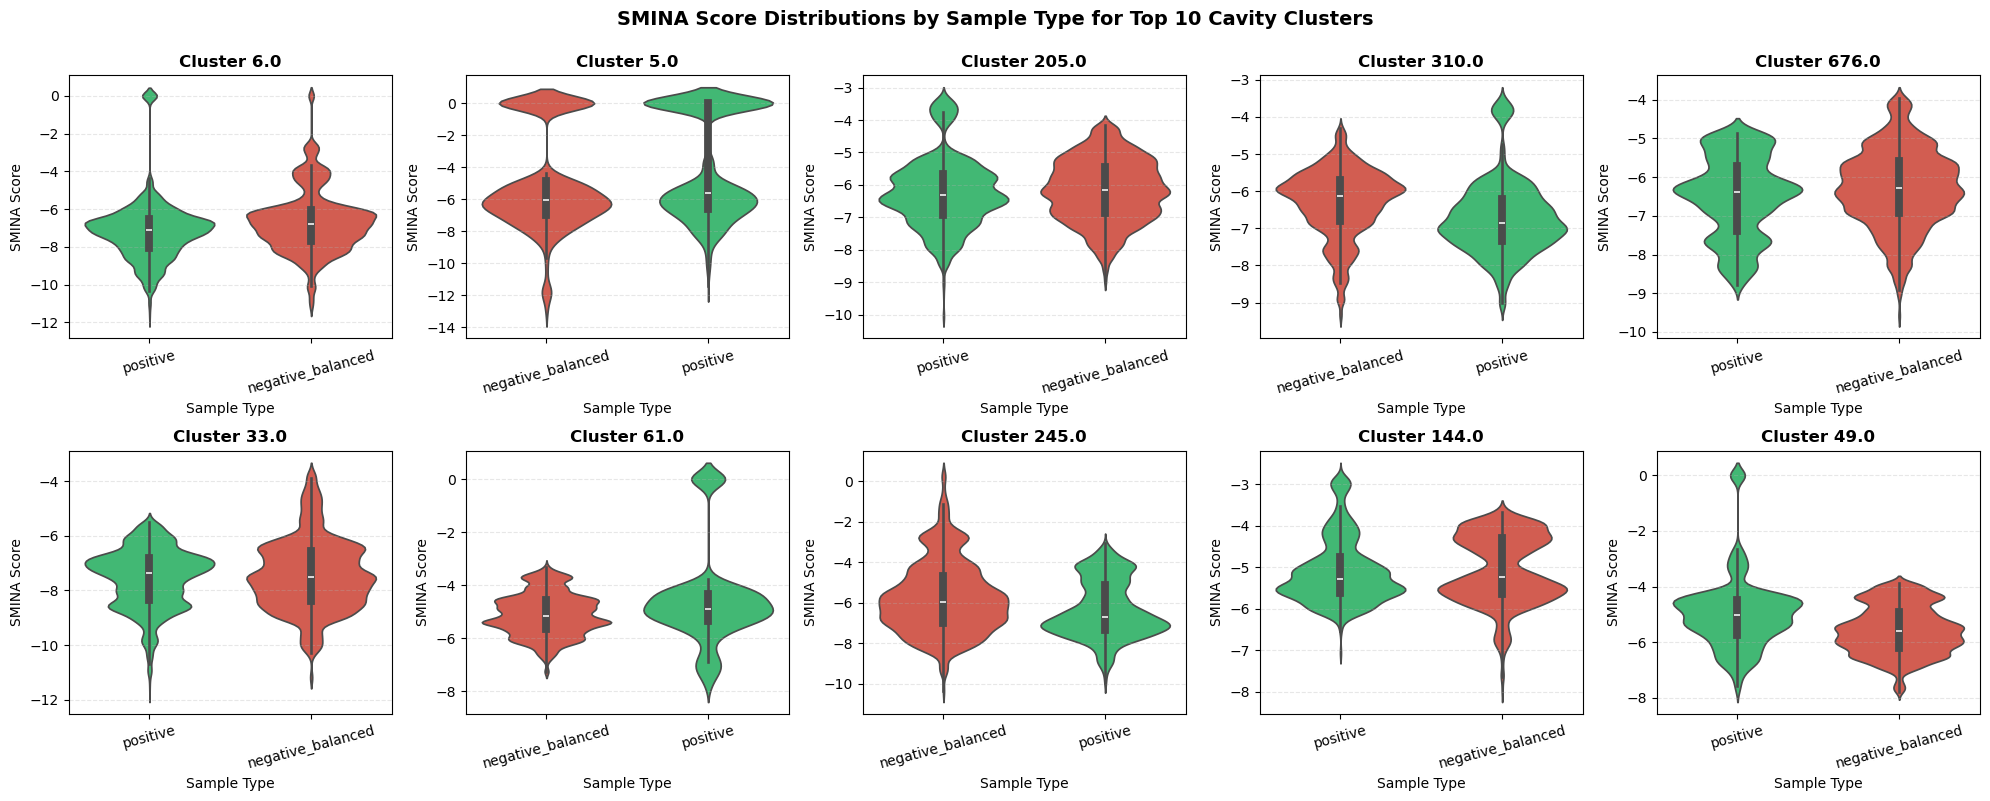

   Plotting LeDock Score...


/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733

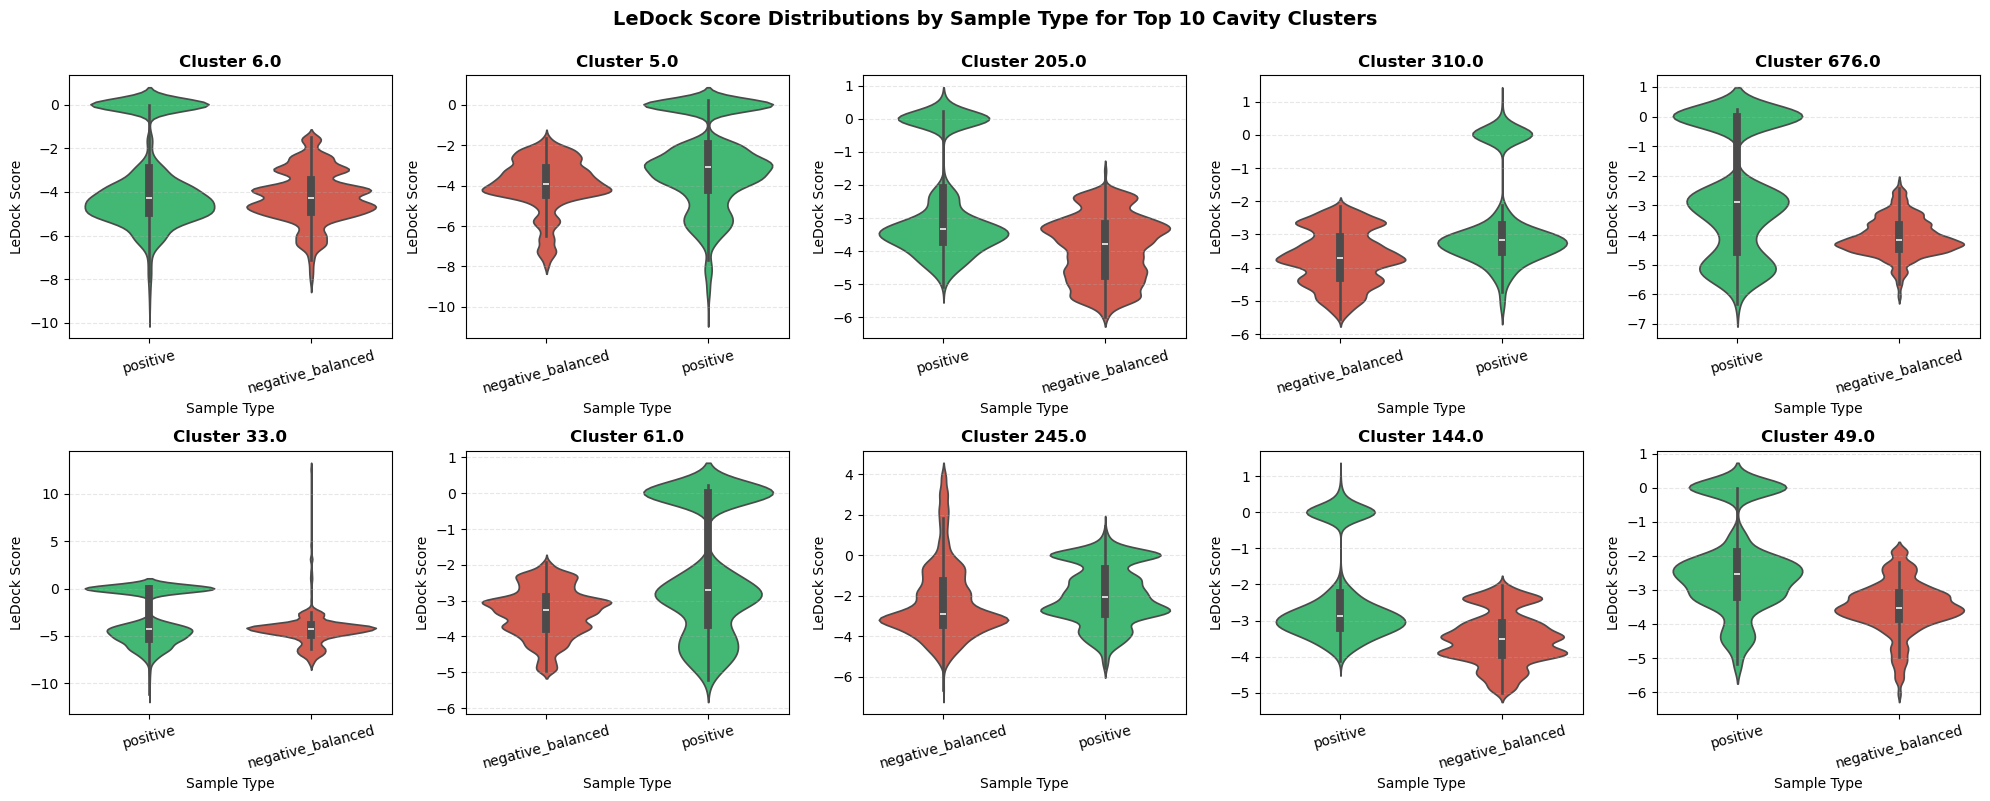

   Plotting GOLD Score...


/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1574525/899674733

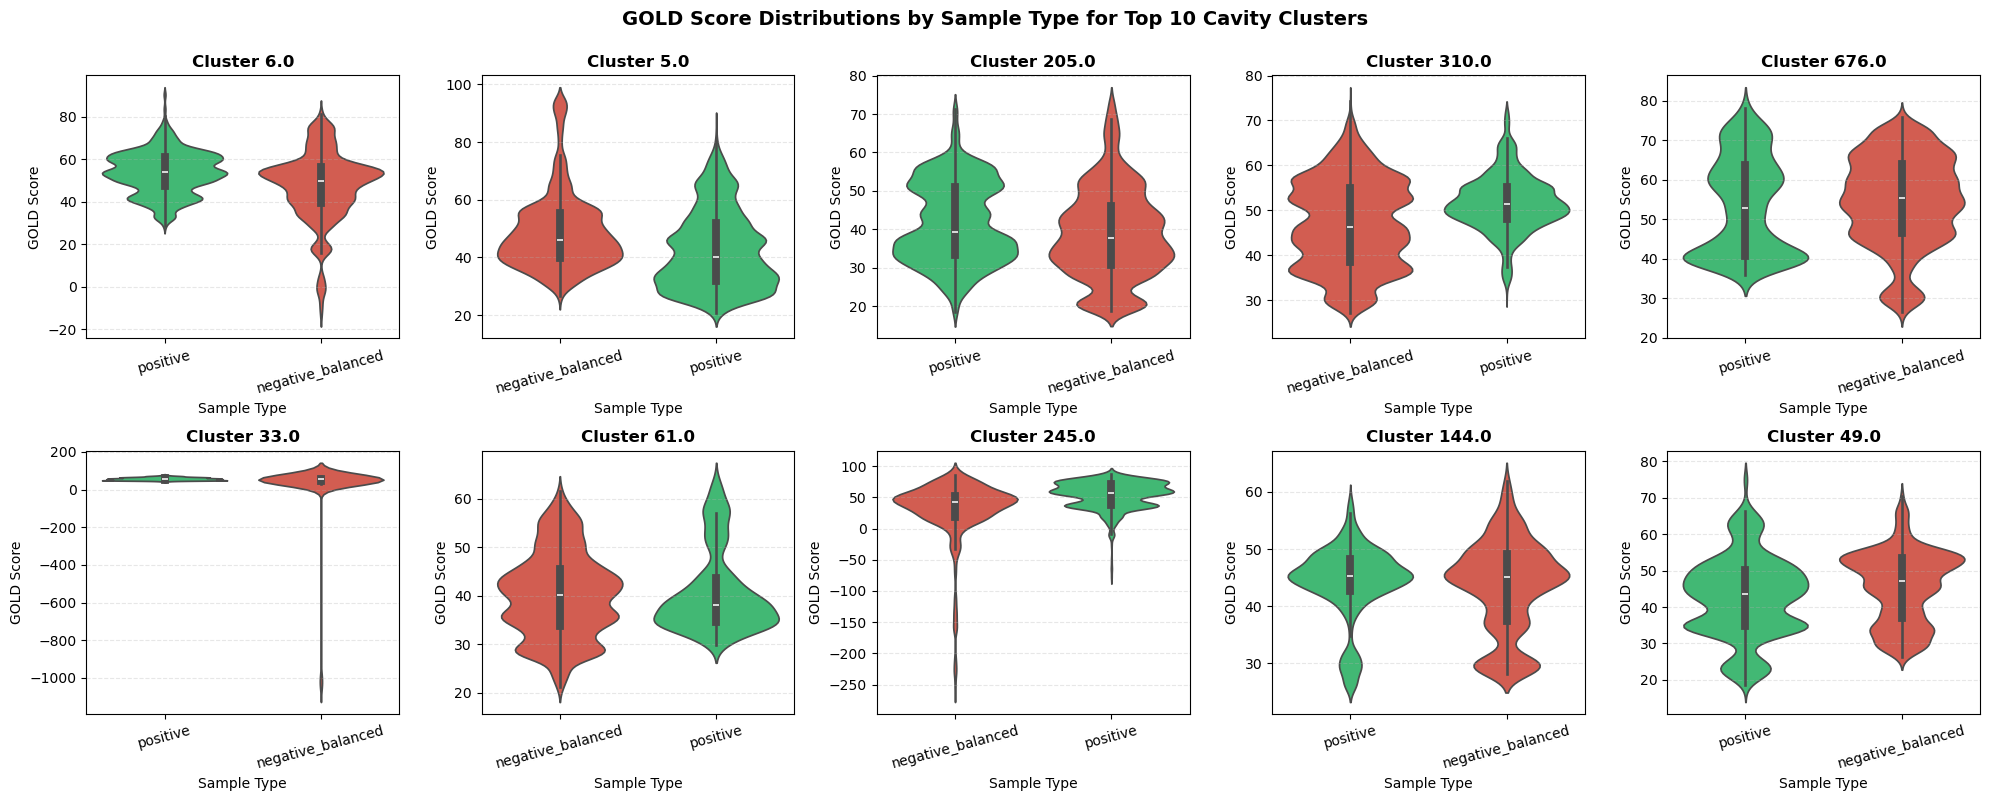

   ✅ Cluster violin plots complete

📈 STEP 7: Generating cavity cluster ROC curves
   Plotting ROC curves for SMINA Score...
   Plotting ROC curves for SMINA Score...


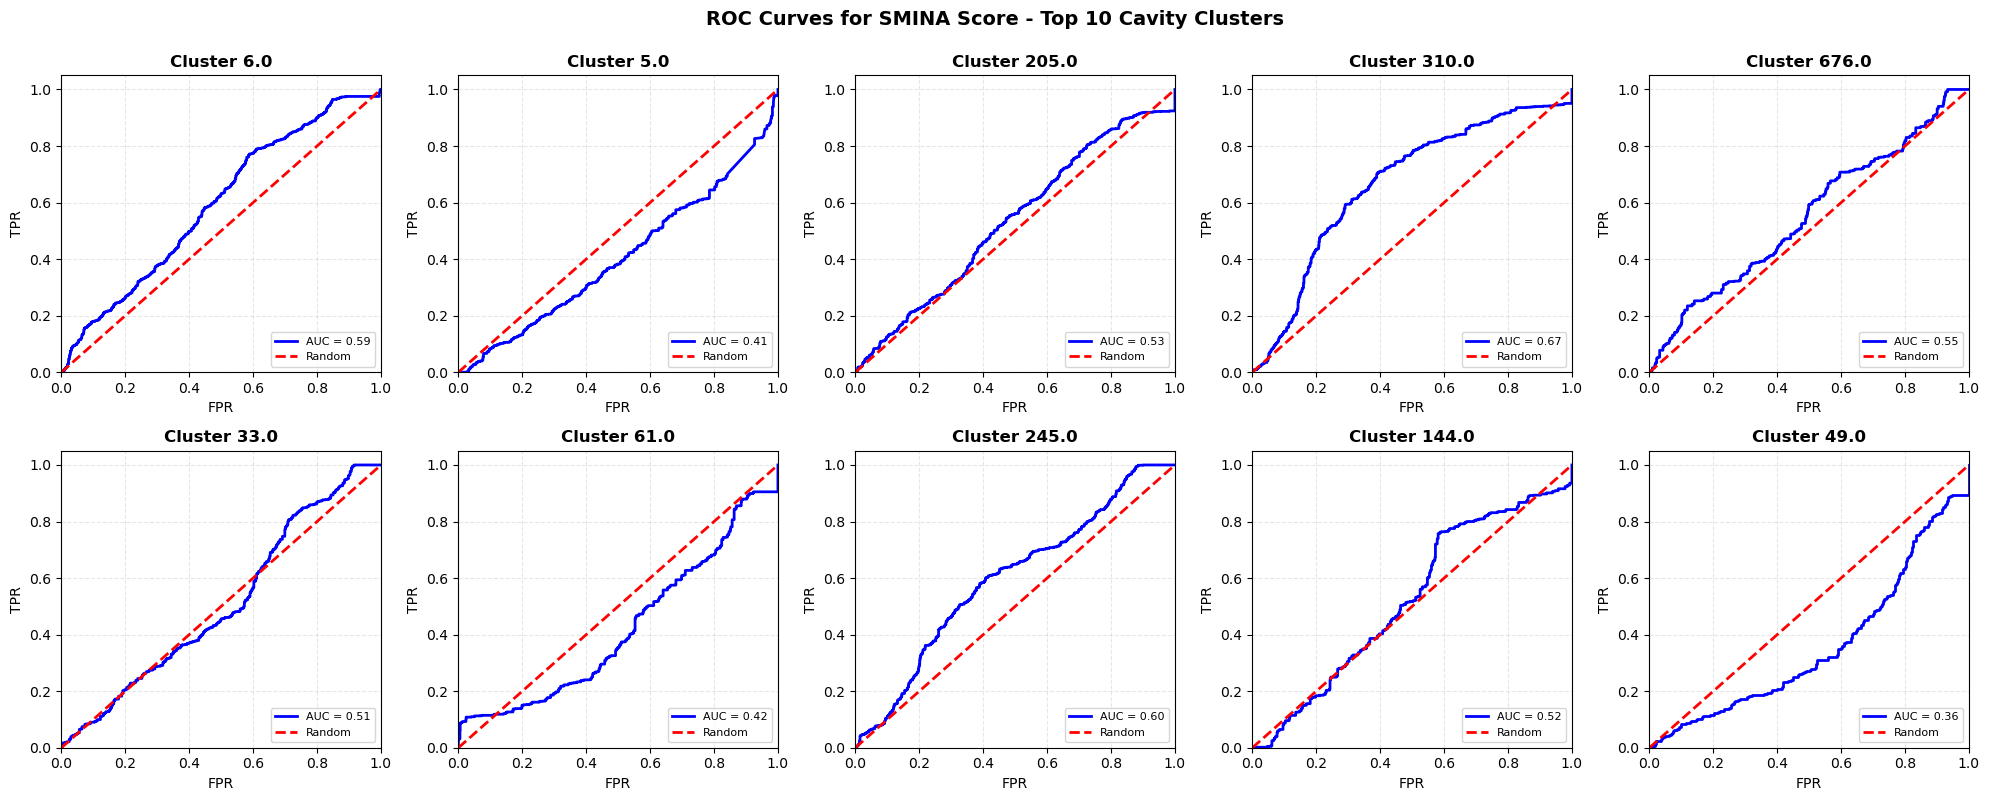

   Plotting ROC curves for LeDock Score...


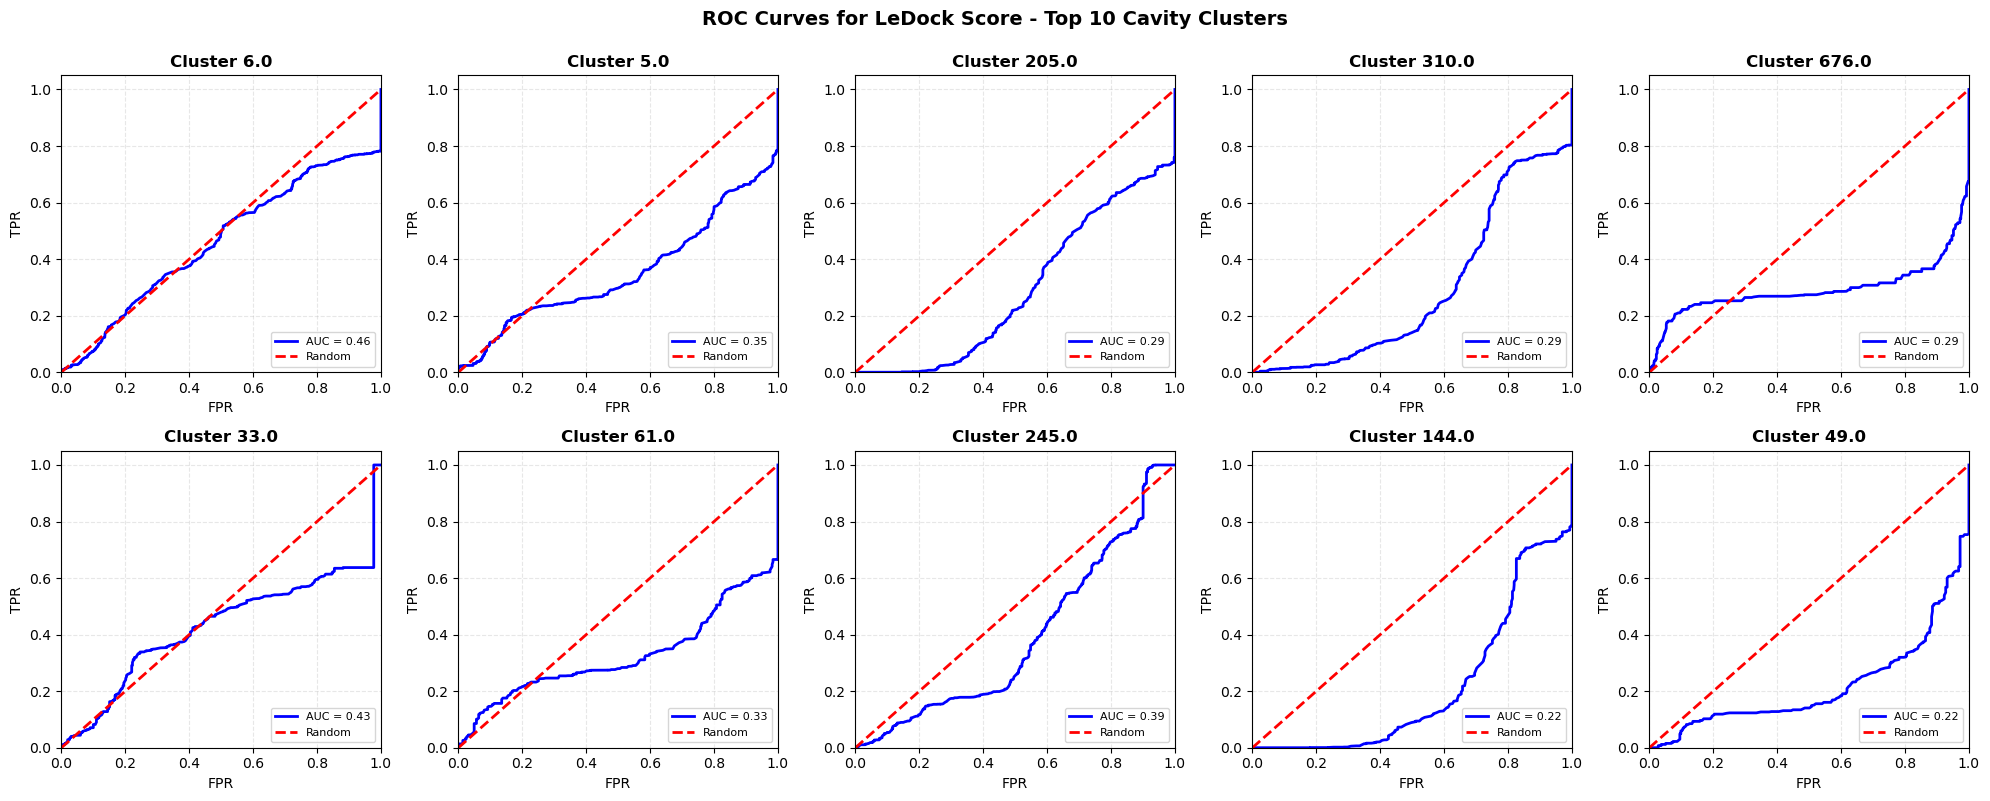

   Plotting ROC curves for GOLD Score...


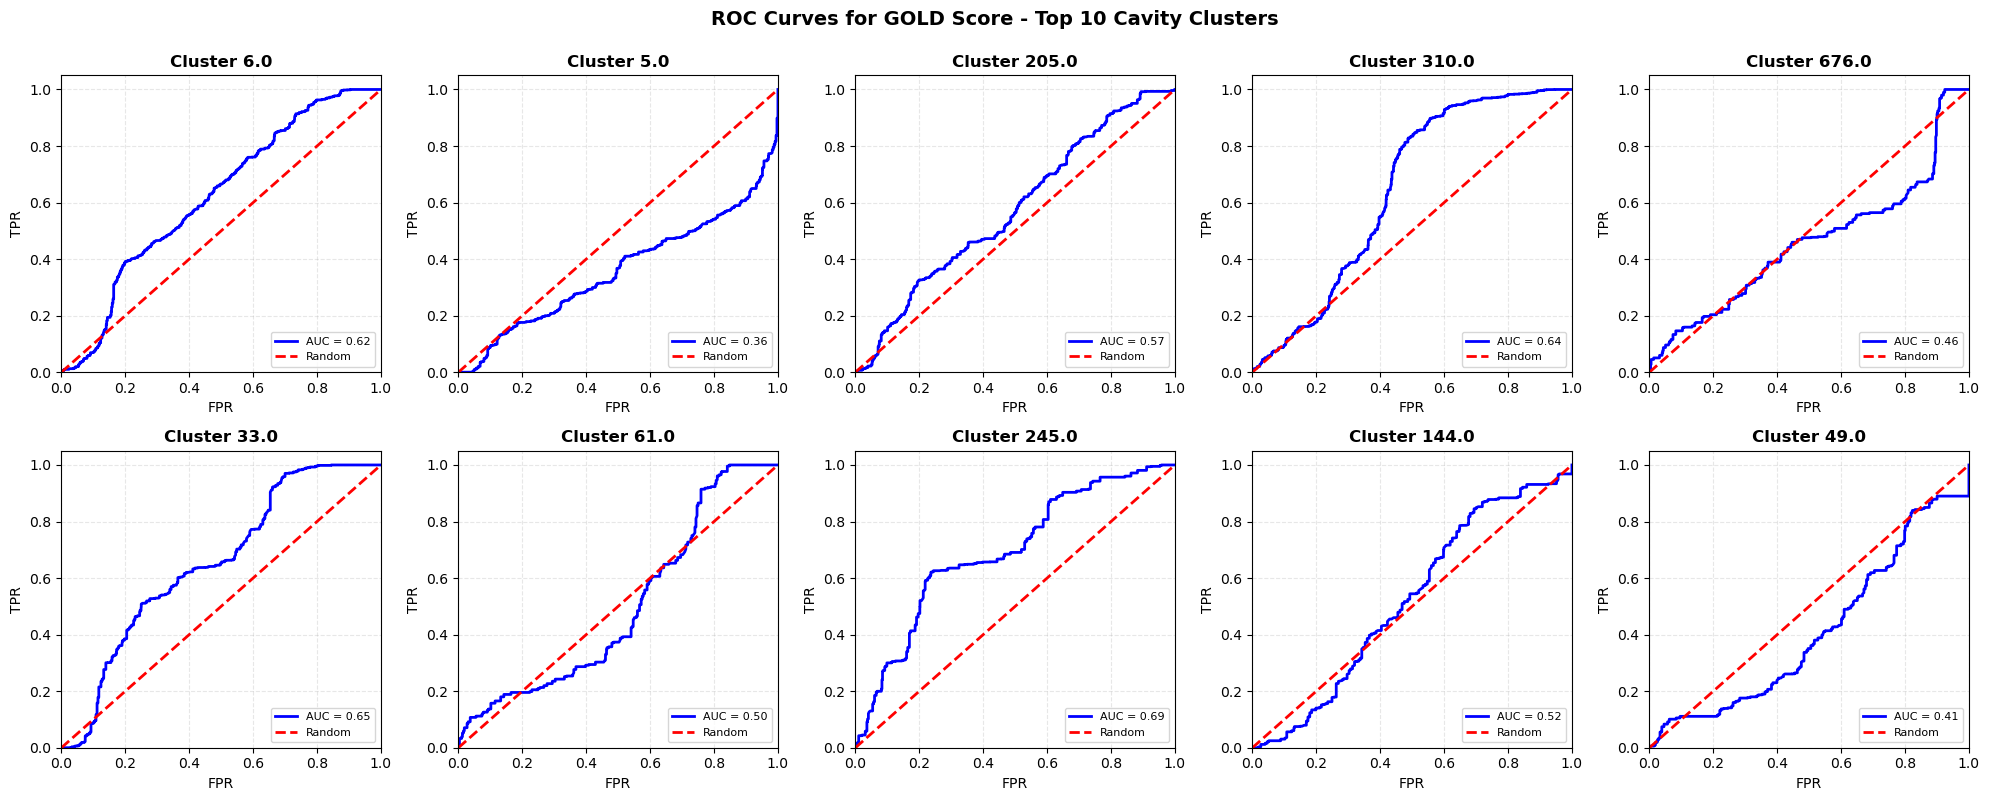

   ✅ Cluster ROC curves complete

✅ ANALYSIS COMPLETE!
   Total figures generated: ~10 plots
   Results dictionary keys: ['stats', 'cluster_counts']


{'stats': {'unique_pairs': 3123,
  'positive_pairs': 1263,
  'negative_pairs': 1860},
 'cluster_counts': shape: (98, 4)
 ┌───────────────────┬──────────────────────────────┬────────────────┬────────────────┐
 │ cavity_cluster_id ┆ unique_compound_target_pairs ┆ positive_pairs ┆ negative_pairs │
 │ ---               ┆ ---                          ┆ ---            ┆ ---            │
 │ i64               ┆ u32                          ┆ i32            ┆ i32            │
 ╞═══════════════════╪══════════════════════════════╪════════════════╪════════════════╡
 │ null              ┆ 2497                         ┆ 1112           ┆ 1385           │
 │ 6                 ┆ 121                          ┆ 76             ┆ 45             │
 │ 245               ┆ 96                           ┆ 46             ┆ 50             │
 │ 5                 ┆ 78                           ┆ 46             ┆ 32             │
 │ 205               ┆ 77                           ┆ 51             ┆ 26             │


In [ ]:
analyze_consensus_docking(
    df_all_poses=combined_results,
    df_best_poses=df_best_pose_consensus,
    top_n_clusters=10
)